In [1]:
import setuptools

In [2]:
import pandas as pd

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [4]:
from sklearn.feature_extraction import DictVectorizer

In [5]:
from sklearn.linear_model import LinearRegression, Lasso

In [6]:
from sklearn.metrics import root_mean_squared_error

In [7]:
import pickle

In [8]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet')

In [9]:
import mlflow

mlflow.set_tracking_uri('sqlite:///mlflow.db')

mlflow.set_experiment('nyc-taxi-experiment')

2024/05/28 10:03:51 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/05/28 10:03:51 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/Users/arrybn/git/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716883431962, experiment_id='1', last_update_time=1716883431962, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [10]:
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.70,1.00,0.5,0.00,0.00,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.00,3.50,0.5,3.75,0.00,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.30,3.50,0.5,3.00,0.00,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.00,3.50,0.5,2.00,0.00,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.90,3.50,0.5,3.20,0.00,1.0,16.10,2.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2964619,2,2024-01-31 23:45:59,2024-01-31 23:54:36,NaN,3.18,NaN,None,107,263,0,15.77,0.00,0.5,2.00,0.00,1.0,21.77,NaN,NaN
2964620,1,2024-01-31 23:13:07,2024-01-31 23:27:52,NaN,4.00,NaN,None,114,236,0,18.40,1.00,0.5,2.34,0.00,1.0,25.74,NaN,NaN
2964621,2,2024-01-31 23:19:00,2024-01-31 23:38:00,NaN,3.33,NaN,None,211,25,0,19.97,0.00,0.5,0.00,0.00,1.0,23.97,NaN,NaN
2964622,2,2024-01-31 23:07:23,2024-01-31 23:25:14,NaN,3.06,NaN,None,107,13,0,23.88,0.00,0.5,5.58,0.00,1.0,33.46,NaN,NaN


In [11]:
def preprocess_dataframe(df, remove_outliers=True, to_str_features=[]):
    df['duration'] = (df.tpep_dropoff_datetime - df.tpep_pickup_datetime).dt.total_seconds() / 60

    df_removed_outliers = df
    
    if remove_outliers:
        df_removed_outliers = df[(df.duration >= 1) & (df.duration <= 60)]

    if len(to_str_features) != 0:
        df_removed_outliers[to_str_features] = df_removed_outliers[to_str_features].astype(str)

    return df_removed_outliers

In [12]:
df_jan_23 = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

In [13]:
len(df_jan_23.columns)

19

In [14]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']
target = 'duration'

In [15]:
df_jan_23_removed_outliers = preprocess_dataframe(df_jan_23, to_str_features=categorical)

/var/folders/np/9mvkq6vd4ds2m9h1f7_w0kfr0000gn/T/ipykernel_3212/759168457.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed_outliers[to_str_features] = df_removed_outliers[to_str_features].astype(str)


In [16]:
df_jan_23.duration.std()

42.59435124195458

In [17]:
num_samples_total = len(df_jan_23)
num_samples_total

3066766

In [18]:
df_jan_23_removed_outliers

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,duration
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.30,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,8.433333
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.90,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,6.316667
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.90,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,12.750000
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.10,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,9.616667
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.40,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,10.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3066761,2,2023-01-31 23:58:34,2023-02-01 00:12:33,NaN,3.05,NaN,None,107,48,0,15.80,0.00,0.5,3.96,0.0,1.0,23.76,NaN,NaN,13.983333
3066762,2,2023-01-31 23:31:09,2023-01-31 23:50:36,NaN,5.80,NaN,None,112,75,0,22.43,0.00,0.5,2.64,0.0,1.0,29.07,NaN,NaN,19.450000
3066763,2,2023-01-31 23:01:05,2023-01-31 23:25:36,NaN,4.67,NaN,None,114,239,0,17.61,0.00,0.5,5.32,0.0,1.0,26.93,NaN,NaN,24.516667
3066764,2,2023-01-31 23:40:00,2023-01-31 23:53:00,NaN,3.15,NaN,None,230,79,0,18.15,0.00,0.5,4.43,0.0,1.0,26.58,NaN,NaN,13.000000


In [19]:
len(df_jan_23_removed_outliers) / num_samples_total

0.9812202822125979

In [20]:
df_jan_23.duration

0           8.433333
1           6.316667
2          12.750000
3           9.616667
4          10.833333
             ...    
3066761    13.983333
3066762    19.450000
3066763    24.516667
3066764    13.000000
3066765    14.400000
Name: duration, Length: 3066766, dtype: float64

In [21]:
df_jan_23_removed_outliers.duration.describe()

count    3.009173e+06
mean     1.420486e+01
std      9.939386e+00
min      1.000000e+00
25%      7.216667e+00
50%      1.155000e+01
75%      1.818333e+01
max      6.000000e+01
Name: duration, dtype: float64

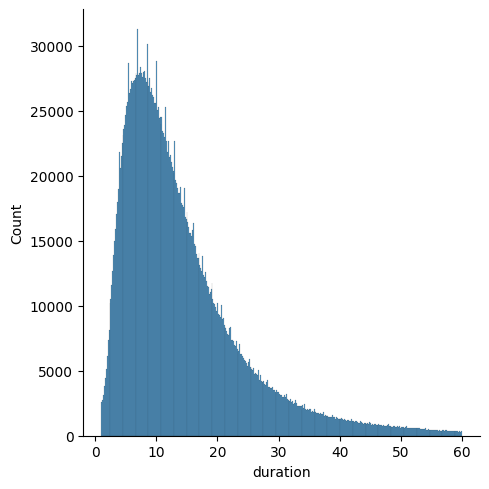

In [22]:
sns.displot(df_jan_23_removed_outliers.duration)

In [23]:
# df_jan_23_removed_outliers[categorical] = df_jan_23_removed_outliers[categorical].astype(str)

In [24]:
df_jan_23_removed_outliers.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[us]
tpep_dropoff_datetime    datetime64[us]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
duration                        float64
dtype: object

In [25]:
df_jan_23_removed_outliers[categorical].iloc[0]

PULocationID    161
DOLocationID    141
Name: 0, dtype: object

In [26]:
def fit_features_transform(df, features_names):
    dicts = df[features_names].to_dict(orient='records')
    dv = DictVectorizer()
    dv.fit(dicts)

    return dv

In [27]:
def get_features_target(df, features_names, target_name, features_transform):
    dicts = df[features_names].to_dict(orient='records')
    X = features_transform.transform(dicts)

    y = df[target_name]

    return X, y

In [28]:
# train_dicts = df_jan_23_removed_outliers[categorical + numerical].to_dict(orient='records')

In [29]:
feature_transform = fit_features_transform(df_jan_23_removed_outliers, categorical + numerical)

In [30]:
len(feature_transform.feature_names_) - 1 # one numeric feature

515

In [31]:
X_train, y_train = get_features_target(df_jan_23_removed_outliers, categorical + numerical, target, feature_transform)

In [32]:
X_train

<3009173x516 sparse matrix of type '<class 'numpy.float64'>'
	with 9027519 stored elements in Compressed Sparse Row format>

In [33]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [34]:
predictions_train = regressor.predict(X_train)

In [35]:
(((predictions_train - y_train)**2).sum() / len(y_train))**0.5

7.658813384236691

In [36]:
root_mean_squared_error(y_train, predictions_train)

7.658813384236691

In [37]:
sorted(predictions_train)[len(predictions_train)//2]

11.93122024908848

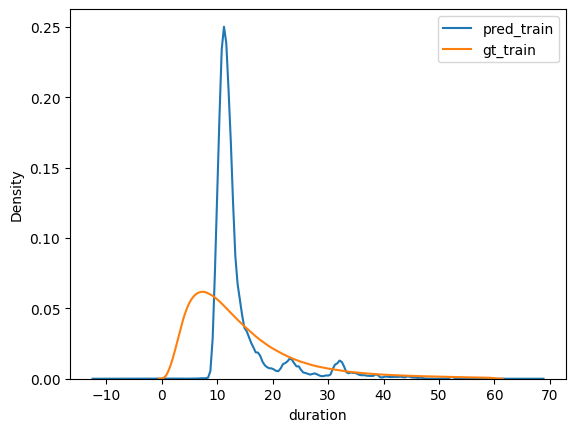

In [38]:
sns.kdeplot(predictions_train, label='pred_train')
sns.kdeplot(y_train, label='gt_train')
plt.legend()

In [39]:
val_df = preprocess_dataframe(pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet'), 
                              to_str_features=categorical)

/var/folders/np/9mvkq6vd4ds2m9h1f7_w0kfr0000gn/T/ipykernel_3212/759168457.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_removed_outliers[to_str_features] = df_removed_outliers[to_str_features].astype(str)


In [40]:
X_val, y_val = get_features_target(val_df, categorical + numerical, target, feature_transform)

In [41]:
pred_val = regressor.predict(X_val)

In [42]:
root_mean_squared_error(y_val, pred_val)

7.820203893965551

In [43]:
pred_val

array([11.37240142, 50.84875858, 15.10540886, ..., 13.53928047,
       10.99123492, 13.18702635])

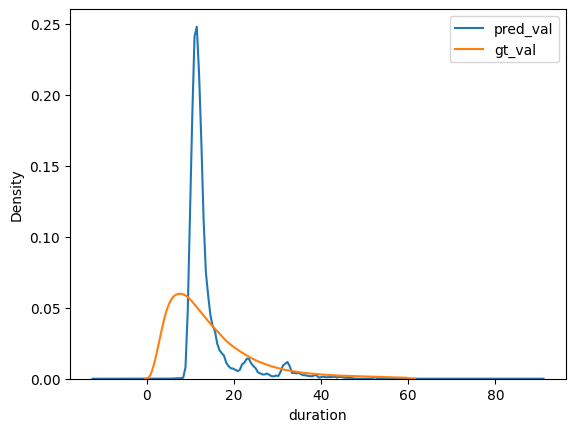

In [44]:
sns.kdeplot(pred_val, label='pred_val')
sns.kdeplot(y_val, label='gt_val')
plt.legend()

In [45]:
with mlflow.start_run():
    mlflow.set_tag('developer', 'aleksandr')
    mlflow.log_param('train-dataset-url', 
                     'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet')

    mlflow.log_param('val-dataset-url', 
                     'https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-02.parquet')

    alpha = 0.1
    mlflow.log_param('alpha', alpha)

    lasso_reg = Lasso(alpha)

    lasso_reg.fit(X_train, y_train)

    pred_val = lasso_reg.predict(X_val)

    rmse = root_mean_squared_error(y_val, pred_val)
    mlflow.log_metric('rmse', rmse)

In [46]:
import xgboost as xgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

from functools import partial

In [47]:

def objective(params, train_dataset, val_dataset):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train_dataset,
            num_boost_round=1000,
            evals=[(val_dataset, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(val_dataset)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [48]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [49]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=partial(objective, train_dataset=train, val_dataset=valid),
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

[10:04:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:12.56649                          
[1]	validation-rmse:9.49681                           
[2]	validation-rmse:7.53563                           
[3]	validation-rmse:6.35157                           
[4]	validation-rmse:5.66899                           
[5]	validation-rmse:5.29513                           
[6]	validation-rmse:5.09563                           
[7]	validation-rmse:4.99289                           
[8]	validation-rmse:4.93727                           
[9]	validation-rmse:4.91361                           
[10]	validation-rmse:4.90024                          
[11]	validation-rmse:4.89702                          
[12]	validation-rmse:4.89746                          
[13]	validation-rmse:4.89991                          
[14]	validation-rmse:4.

KeyboardInterrupt: 

In [ ]:
params = \
    '''learning_rate
    0.1405477975575058
    max_depth
    16
    min_child_weight
    4.433597766696137
    objective
    reg:linear
    reg_alpha
    0.054955814765758795
    reg_lambda
    0.018320958637703375
    seed
    42'''

params = params.split('\n')
params = {p0.strip(): p1.strip() for (p0, p1) in zip(params[::2], params[1::2])}

for k,v in params.items():
    try:
        params[k] = int(v)
        continue
    except ValueError:
        pass

    try:
        params[k] = float(v)
    except ValueError:
        pass

params

{'learning_rate': 0.1405477975575058,
 'max_depth': 16,
 'min_child_weight': 4.433597766696137,
 'objective': 'reg:linear',
 'reg_alpha': 0.054955814765758795,
 'reg_lambda': 0.018320958637703375,
 'seed': 42}

In [ ]:
mlflow.xgboost.autolog(disable=True)

with mlflow.start_run():
    
    mlflow.log_params(params)

    booster = xgb.train(
        params=params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    pred_val = booster.predict(valid)

    rmse = root_mean_squared_error(y_val, pred_val)

    mlflow.log_metric('rmse', rmse)

    with open('models/preprocessor.b', 'wb') as f:
        pickle.dump(feature_transform, f)

    mlflow.log_artifact('models/preprocessor.b', artifact_path='preprocessor')

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")



/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:09:23] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:9.04284
[1]	validation-rmse:8.19718
[2]	validation-rmse:7.50672
[3]	validation-rmse:6.94658
[4]	validation-rmse:6.49559
[5]	validation-rmse:6.13564
[6]	validation-rmse:5.85076
[7]	validation-rmse:5.62603
[8]	validation-rmse:5.44873
[9]	validation-rmse:5.30960
[10]	validation-rmse:5.20090
[11]	validation-rmse:5.11531
[12]	validation-rmse:5.04922
[13]	validation-rmse:4.99494
[14]	validation-rmse:4.95246
[15]	validation-rmse:4.91747
[16]	validation-rmse:4.88986
[17]	validation-rmse:4.86780
[18]	validation-rmse:4.84939
[19]	validation-rmse:4.83203
[20]	validation-rmse:4.81844
[21]	validation-rmse:4.80656
[22]	validation-rmse:4.79657
[23]	validation-rmse:4.78880
[24]	validation-rmse:4.78065
[25]	validation-rmse:4.77268
[26]	validation-rmse:4.76596
[27]	validation-rmse:4.76123
[28]	validation-rmse:4.75612
[29]	validation-rmse:4.75296
[30]	validation-rmse:4.74907
[31]	validation-rmse:4.74457
[32]	validation-rmse:4.74123
[33]	validation-rmse:4.73610
[34]	validation-rmse:4.7

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:11:20] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [ ]:
logged_model = 'runs:/6c519749b231421884772376e7731648/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
pred = loaded_model.predict(pd.DataFrame(X_val))

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:14:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/data.py:1037: UserWarning: Unknown data type: <class 'xgboost.core.DMatrix'>, trying to convert it to csr_matrix
  warnings.warn(


TypeError: Not supported type for data.<class 'xgboost.core.DMatrix'>

In [ ]:
loaded_model_xgboost = mlflow.xgboost.load_model(model_uri='runs:/6c519749b231421884772376e7731648/models_mlflow')

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [09:16:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [ ]:
pred = loaded_model_xgboost.predict(valid)

In [ ]:
root_mean_squared_error(y_val, pred)

4.52455231859435

In [ ]:
import setuptools
importlib.reload(setuptools)

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


AssertionError: /opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/distutils/core.py

In [ ]:
!pip install --upgrade setuptools

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 863.4/863.4 kB 4.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: setuptools
    Found existing installation: setuptools 68.0.0
    Uninstalling setuptools-68.0.0:
      Successfully uninstalled setuptools-68.0.0


In [ ]:
import distutils

from sklearn.utils import all_estimators
estimators = all_estimators()

/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


AssertionError: /opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/distutils/core.py

In [ ]:
pred_val

array([ 6.78157454, 41.4045318 , 15.34599035, ..., 15.50017006,
       10.71969955, 13.02144907])

In [ ]:
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

with mlflow.start_run():
    lin_svr = LinearSVR()
    lin_svr.fit(X_train, y_train)

    pred_val = lin_svr.predict(X_val)
    rmse = root_mean_squared_error(y_val, pred_val)

    mlflow.log_metric('rmse', rmse)



2024/05/24 09:42:50 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'
/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
2024/05/24 09:46:27 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/aleksandrrybnikov/work/git/mlops-zoomcamp/.venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:26: UserWarning: Setuptools is replacing distutils."


In [ ]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        # mlflow.log_param("train-data-path", "./data/green_tripdata_2021-01.csv")
        # mlflow.log_param("valid-data-path", "./data/green_tripdata_2021-02.csv")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = root_mean_squared_error(y_val, y_pred)
        mlflow.log_metric("rmse", rmse)

2024/05/24 09:52:06 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'toarray'


KeyboardInterrupt: 